In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/ML4RG Joint Model/data"

/content/drive/.shortcut-targets-by-id/1naLfQnowal893vw9wi-yc7tBoaLeMW9V/ML4RG Joint Model/data


In [ ]:
!pip install pyarrow
!pip install pyranges

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyranges as pr
import os

In [ ]:
REGION_PATH = os.path.join(os.getcwd(), 'regions.parquet')
DATA_PATH = os.path.join(os.getcwd(), 'data.npz')
ENSEMBL_PATH = os.path.join(os.getcwd(), 'ensembl_annotation.gff3')

In [ ]:
# ── 1. Regions.parquet ────────────────────────────────────────────────────────
regions = pd.read_parquet(REGION_PATH)

print(regions.head(10))

print("\nRegion summary:")
print(regions.describe())

  contig strand  start  offset  window_size  num_expressed
0   chrI      +   7655    7655         2048            205
1   chrI      +   7656    7656         2048            206
2   chrI      +   7657    7657         2048            207
3   chrI      +   7658    7658         2048            208
4   chrI      +   7659    7659         2048            209
5   chrI      +   7660    7660         2048            210
6   chrI      +   7661    7661         2048            211
7   chrI      +   7662    7662         2048            212
8   chrI      +   7663    7663         2048            213
9   chrI      +   7664    7664         2048            214

Region summary:
              start        offset  window_size  num_expressed
count  1.570582e+07  1.570582e+07   15705825.0   1.570582e+07
mean   4.583180e+05  6.091603e+06       2048.0   1.166063e+03
std    3.211310e+05  3.496248e+06          0.0   5.484582e+02
min    0.000000e+00  3.665000e+03       2048.0   2.050000e+02
25%    1.944050e+05  3.0

In [ ]:
print("\nLoading NPZ data…")
npz = np.load(DATA_PATH)
print("Arrays in data.npz:", npz.files)
for name in npz.files:
    print(f"  {name:20s} → shape {npz[name].shape}")


Loading NPZ data…
Arrays in data.npz: ['sequence', 'expressed_plus', 'expressed_minus']
  sequence             → shape (12157105,)
  expressed_plus       → shape (12157105,)
  expressed_minus      → shape (12157105,)


In [ ]:
print("\nParsing annotation file as GFF3…")
rows = []
with open(ENSEMBL_PATH) as f:
    for line in f:
        if line.startswith('#'):
            continue
        cols = line.strip().split('\t')
        if len(cols) == 9:
            rows.append(cols)

gff3 = pd.DataFrame(rows, columns=[
    'seqid','source','type','start','end','score','strand','phase','attributes'
])
# convert coordinates to int
gff3[['start','end']] = gff3[['start','end']].astype(int)

print("\nFirst 10 annotation entries:")
print(gff3.head(10))

print("\nFeature type counts:")
print(gff3['type'].value_counts())

# e.g. compute gene lengths if you have type=='gene'
if 'gene' in gff3['type'].unique():
    genes = gff3[gff3['type'] == 'gene'].copy()
    genes['gene_length'] = genes['end'] - genes['start'] + 1
    print("\nGene length summary:")
    print(genes['gene_length'].describe())


Parsing annotation file as GFF3…

First 10 annotation entries:
  seqid   source        type  start     end score strand phase  \
0     I  R64-1-1  chromosome      1  230218     .      .     .   
1     I      sgd        gene    335     649     .      +     .   
2     I      sgd        mRNA    335     649     .      +     .   
3     I      sgd        exon    335     649     .      +     .   
4     I      sgd         CDS    335     649     .      +     0   
5     I      sgd        gene    538     792     .      +     .   
6     I      sgd        mRNA    538     792     .      +     .   
7     I      sgd        exon    538     792     .      +     .   
8     I      sgd         CDS    538     792     .      +     0   
9     I      sgd        gene   1807    2169     .      -     .   

                                          attributes  
0                   ID=chromosome:I;Alias=BK006935.2  
1  ID=gene:YAL069W;biotype=protein_coding;descrip...  
2  ID=transcript:YAL069W_mRNA;Parent=gene:YA

In [ ]:
import torch
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split

class GenomeExpressionDataset(Dataset):
    """
    Custom Dataset for genomic windows: loads sequence and expression arrays,
    and regions from a parquet file. Returns one-hot encoded sequence, a binary
    expression label, and metadata.
    """
    def __init__(self, region_path, npz_path):
        # Load regions
        try:
            self.regions = pd.read_parquet(region_path)
        except Exception as e:
            raise RuntimeError(f"Could not load regions from '{region_path}': {e}")

        # Load .npz arrays
        try:
            data = np.load(npz_path)
            self.seq_flat   = data['sequence']
            self.expr_plus  = (data['expressed_plus'] > 0).astype(np.int64)
            self.expr_minus = (data['expressed_minus'] > 0).astype(np.int64)
        except Exception as e:
            raise RuntimeError(f"Could not load NPZ data from '{npz_path}': {e}")

        # One-hot parameters
        self.num_bases = 5  # A, C, G, T, N

    def __len__(self):
        return len(self.regions)

    def _one_hot(self, arr):
        """
        One-hot encode an integer array of length L into (L, num_bases) float tensor.
        """
        L = arr.shape[0]
        oh = torch.zeros(L, self.num_bases, dtype=torch.float32)
        idx = torch.tensor(arr, dtype=torch.long).unsqueeze(1)
        oh.scatter_(1, idx, 1.0)
        return oh

    def __getitem__(self, idx):
        # Allow tensor indices
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.regions.iloc[idx]
        off = int(row.offset)
        L   = int(row.window_size)
        strand = row.strand

        # Slice sequence and one-hot encode
        seq_segment = self.seq_flat[off:off+L]
        oh_seq = self._one_hot(seq_segment)  # (L,5)

        # Choose expression label by strand
        try:
            if strand == '+':
                lbl = int(self.expr_plus[off])
            else:
                lbl = int(self.expr_minus[off])
        except IndexError:
            raise RuntimeError(f"Offset {off} out of bounds for expression array of length {len(self.expr_plus)}")

        return oh_seq, torch.tensor(lbl, dtype=torch.long), {
            'contig': row.contig,
            'start': row.start,
            'strand': strand,
            'offset': off
        }

# Instantiate and test within try/except
try:
    dataset = GenomeExpressionDataset(REGION_PATH, DATA_PATH)
    print("Successfully instantiated GenomeExpressionDataset.")
    print("Total regions:", len(dataset))

    # Fetch example samples
    for i in [0, len(dataset)//2, len(dataset)-1]:
        seq_tensor, label, meta = dataset[i]
        print(f"\nIndex {i}:")
        print(" Sequence shape:", seq_tensor.shape)
        print(" Label:", label.item())
        print(" Meta:", meta)

    # DataLoader usage
    batch_size = 8
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    for batch_idx, (seqs, labels, metas) in enumerate(loader):
        print(f"\nBatch {batch_idx}: seqs {seqs.shape}, labels {labels.numpy()}")
        print(" First metadata item:", {k: metas[k][0] for k in metas})
        if batch_idx >= 1:
            break

except RuntimeError as e:
    print("Error:", e)
except Exception as e:
    print("Unexpected error:", e)

# 1) Instantiate the dataset
dataset = GenomeExpressionDataset(REGION_PATH, DATA_PATH)
print(f"Total windows (samples): {len(dataset)}")

# 2) Peek at a single sample
seq_tensor, label, metadata = dataset[0]
print("Sample #0:")
print(" - Sequence tensor shape:", seq_tensor.shape)  # (window_size, 5)
print(" - Label (0/1):", label.item())
print(" - Metadata:", metadata)

# 3) Split into train / validation sets (e.g. 80/20)
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(0))
print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}")

Successfully instantiated GenomeExpressionDataset.
Total regions: 15705825

Index 0:
 Sequence shape: torch.Size([2048, 5])
 Label: 0
 Meta: {'contig': 'chrI', 'start': np.int64(7655), 'strand': '+', 'offset': 7655}

Index 7852912:
 Sequence shape: torch.Size([2048, 5])
 Label: 0
 Meta: {'contig': 'chrX', 'start': np.int64(582636), 'strand': '+', 'offset': 6415097}

Index 15705824:
 Sequence shape: torch.Size([2048, 5])
 Label: 1
 Meta: {'contig': 'chrM', 'start': np.int64(61450), 'strand': '+', 'offset': 12132776}

Batch 0: seqs torch.Size([8, 2048, 5]), labels [0 0 1 0 1 0 1 0]
 First metadata item: {'contig': 'chrXV', 'start': tensor(78194), 'strand': '-', 'offset': tensor(10110163)}

Batch 1: seqs torch.Size([8, 2048, 5]), labels [0 0 1 0 0 0 0 0]
 First metadata item: {'contig': 'chrXIV', 'start': tensor(520797), 'strand': '+', 'offset': tensor(9768433)}
Total windows (samples): 15705825
Sample #0:
 - Sequence tensor shape: torch.Size([2048, 5])
 - Label (0/1): 0
 - Metadata: {'co

In [ ]:
# 4) Wrap in DataLoaders for batching
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

# 5) Iterate through one training batch
for batch_idx, (seq_batch, label_batch, meta_batch) in enumerate(train_loader):
    print(f"\nBatch {batch_idx + 1}")
    print(" - seq_batch shape:", seq_batch.shape)   # (batch_size, window_size, 5)
    print(" - label_batch shape:", label_batch.shape) # (batch_size,)
    # meta_batch is a dict of lists (one entry per sample in batch)
    print(" - meta example:", {k: meta_batch[k][0] for k in meta_batch})
    break  # just show the first batch


Batch 1
 - seq_batch shape: torch.Size([16, 2048, 5])
 - label_batch shape: torch.Size([16])
 - meta example: {'contig': 'chrI', 'start': tensor(156629), 'strand': '-', 'offset': tensor(156629)}


### Sequence‐Level Visualization

In [ ]:
# # Load
# npz      = np.load(DATA_PATH)
# seq_flat = npz['sequence']
# regions  = pd.read_parquet(REGION_PATH)
# offsets  = regions['offset'].values.astype(int)
# window_size = int(regions['window_size'].iat[0])

# # Build a sample of windows
# n_windows = 500
# seq_windows = np.stack([
#     seq_flat[offsets[i] : offsets[i] + window_size]
#     for i in range(n_windows)
# ])

# # One-hot encode (A=0,C=1,G=2,T=3)
# def one_hot(seqs, alphabet_size=4):
#     n, L = seqs.shape
#     oh = np.zeros((n, L, alphabet_size), dtype=int)
#     for b in range(alphabet_size):
#         oh[:, :, b] = (seqs == b)
#     return oh

# oh = one_hot(seq_windows)

# # Compute position-frequency matrix
# counts = oh.sum(axis=0)  # shape: (window_size, 4)
# freqs  = counts / counts.sum(axis=1, keepdims=True)

# # Plot stacked‐bar “logo”
# letters = ['A','C','G','T']
# colors  = {'A':'green','C':'blue','G':'orange','T':'red'}

# pos  = np.arange(window_size)
# bottom = np.zeros(window_size)

# plt.figure(figsize=(12,4))
# for i, base in enumerate(letters):
#     h = freqs[:, i]
#     plt.bar(pos, h, bottom=bottom, color=colors[base], width=1.0, edgecolor='none', label=base)
#     bottom += h

# plt.xlabel("Position in Window")
# plt.ylabel("Nucleotide Frequency")
# plt.title(f"Sequence Logo (first {n_windows} windows)")
# plt.legend(loc='upper right')
# plt.tight_layout()
# plt.show()

### "expressed vs unexpressed" and "exonic vs intronic"

In [ ]:
# # ── 1) Load the raw data ───────────────────────────────────────────────────────

# SAMPLE_SIZE  = 500
# RANDOM_SEED  = 42
# np.random.seed(RANDOM_SEED)
# npz       = np.load(DATA_PATH)
# seq_flat  = npz['sequence']
# expr_flat = npz['expressed_plus']

# regions        = pd.read_parquet(REGION_PATH)
# window_size    = int(regions['window_size'].iat[0])
# regions = regions.reset_index().rename(columns={'index':'orig_idx'})

# # Build a PyRanges object for windows
# windows_df = pd.DataFrame({
#     'Chromosome': regions['contig'].str.replace('chr',''),
#     'Start':      regions['start'],
#     'End':        regions['start'] + window_size - 1,
#     'idx':        regions['orig_idx']
# })
# pr_windows = pr.PyRanges(windows_df)

# # ── 2) Load exons into PyRanges ────────────────────────────────────────────────
# exon_list = []
# with open(ENSEMBL_PATH) as f:
#     for line in f:
#         if line.startswith('#'):
#             continue
#         seqid, _, feature, st, en, *_ = line.strip().split('\t')
#         if feature == 'exon':
#             exon_list.append({
#                 'Chromosome': seqid.replace('chromosome:',''),
#                 'Start':      int(st),
#                 'End':        int(en),
#             })
# exons_df  = pd.DataFrame(exon_list)
# pr_exons  = pr.PyRanges(exons_df)

# # ── 3) Vectorized overlap ─────────────────────────────────────────────────────
# # find which windows overlap any exon
# joined    = pr_windows.join(pr_exons)
# exon_idxs = joined.df['idx'].unique()

# # create boolean masks
# labels_exon = np.zeros(len(regions), dtype=bool)
# labels_exon[exon_idxs] = True

# # ── 4) Label expressed windows ────────────────────────────────────────────────
# # by scanning the flat array in vectorized batches
# offsets     = regions.set_index('orig_idx')['offset']
# # For memory, you can do this in chunks; here’s a full‐vector version:
# wstarts     = regions['start'].values.astype(int)
# # any expressed in each window?
# labels_expr = np.array([
#     expr_flat[s:s+window_size].any()
#     for s in wstarts
# ], dtype=bool)

# # ── 5) Sample balanced indices ────────────────────────────────────────────────
# def sample(sel):
#     pos = np.where(sel)[0]
#     neg = np.where(~sel)[0]
#     npos = min(len(pos), SAMPLE_SIZE)
#     nneg = min(len(neg), SAMPLE_SIZE)
#     return (np.random.choice(pos, npos, replace=False),
#             np.random.choice(neg, nneg, replace=False))

# expr_pos, expr_neg = sample(labels_expr)
# exon_pos, exon_neg = sample(labels_exon)

In [ ]:
# # ── 6) One‐hot & PFMs & plot ────────────────────────────────────────────────
# def fetch_and_onehot(idxs):
#     arr = np.stack([seq_flat[offsets[i]:offsets[i]+window_size] for i in idxs])
#     B, L = arr.shape
#     oh = np.zeros((B, L, 4), int)
#     for b in range(4):
#         oh[:,:,b] = (arr == b)
#     return oh

# def pfm(oh):
#     c = oh.sum(axis=0)
#     return c / c.sum(axis=1, keepdims=True)

# oh_ep = fetch_and_onehot(expr_pos);   pfm_ep = pfm(oh_ep)
# oh_en = fetch_and_onehot(expr_neg);   pfm_en = pfm(oh_en)
# oh_xp = fetch_and_onehot(exon_pos);   pfm_xp = pfm(oh_xp)
# oh_xn = fetch_and_onehot(exon_neg);   pfm_xn = pfm(oh_xn)

# def plot_logo(p, ax, title):
#     bases, colors = ['A','C','G','T'], ['green','blue','orange','red']
#     L = p.shape[0]; pos = np.arange(L); bot = np.zeros(L)
#     for i,c in enumerate(colors):
#         ax.bar(pos, p[:,i], bottom=bot, color=c, width=1, edgecolor='none')
#         bot += p[:,i]
#     ax.set_title(title); ax.set_xlim(0,L); ax.set_ylim(0,1)
#     ax.set_xlabel("Position"); ax.set_ylabel("Freq.")

# fig, axes = plt.subplots(2,2,figsize=(14,8),sharex=True,sharey=True)
# plot_logo(pfm_ep, axes[0,0], "Expressed")
# plot_logo(pfm_en, axes[0,1], "Unexpressed")
# plot_logo(pfm_xp, axes[1,0], "Exonic")
# plot_logo(pfm_xn, axes[1,1], "Intronic")
# fig.suptitle(f"Sequence Logos (≤{SAMPLE_SIZE} windows per class)", y=0.95)
# plt.tight_layout(rect=[0,0,1,0.94])
# plt.show()

In [ ]:
# # ── Config ─────────────────────────────────────────────────────────────────────
# FLANK     = 20       # ± bp around junction
# SAMPLE_JX = 1000     # how many junctions to sample
# SEED      = 0

# # ── 1) Load the flat arrays and regions table ─────────────────────────────────
# np.random.seed(SEED)
# data    = np.load(DATA_PATH)
# seq     = data['sequence']   # A=0, C=1, G=2, T=3, N=4

# # We only need contig/start→offset to map back positions
# regions = pd.read_parquet(REGION_PATH)[['contig','start','offset']]
# regions = regions.rename(columns={'start':'pos'})

# # ── 2) Read & sample plus‐strand exons ────────────────────────────────────────
# cols = ['seqid','source','type','start','end','score','strand','phase','attr']
# gff = (pd.read_csv(ENSEMBL_PATH, sep='\t', comment='#', names=cols)
#          .query("type=='exon' & strand=='+'")
#          .assign(contig=lambda df: 'chr'+df.seqid)
#       )

# gff = gff.sample(n=min(SAMPLE_JX, len(gff)), random_state=SEED).reset_index(drop=True)
# gff['jx_id'] = gff.index  # unique ID per junction

# # ── 3) Build donor/acceptor position tables ──────────────────────────────────
# def build_jx_df(gff, kind):
#     # kind = 'donor' uses exon end; 'acceptor' uses exon start
#     centers = gff.end.values if kind=='donor' else gff.start.values
#     n = len(gff)
#     # for each junction, list 2*FLANK positions
#     pos = np.hstack([np.arange(c-FLANK, c+FLANK) for c in centers])
#     return pd.DataFrame({
#         'contig': np.repeat(gff.contig.values, 2*FLANK),
#         'pos':    pos,
#         'jx_id':  np.repeat(gff.jx_id.values, 2*FLANK),
#     })

# donor_df    = build_jx_df(gff, 'donor')
# acceptor_df = build_jx_df(gff, 'acceptor')

# # ── 4) Merge with regions to get flat‐array offsets ───────────────────────────
# donor_map    = donor_df.merge(regions, how='left', on=['contig','pos'])
# acceptor_map = acceptor_df.merge(regions, how='left', on=['contig','pos'])

# # ── 5) Filter to only full‐length windows and stack offsets ──────────────────
# def extract_offsets(jx_map):
#     # drop missing, group by jx_id, keep only groups of length 2*FLANK
#     gm = (jx_map
#           .dropna(subset=['offset'])
#           .groupby('jx_id')['offset']
#           .apply(list))
#     good = gm[gm.map(len) == 2*FLANK]
#     return np.vstack(good.values).astype(int)

# donor_off    = extract_offsets(donor_map)     # shape (n_good, 2*FLANK)
# acceptor_off = extract_offsets(acceptor_map)

# # ── 6) Slice the flat sequence, one‐hot, and compute PFMs ────────────────────
# donor_arr    = np.take(seq, donor_off)        # (n_good, 2*FLANK)
# acceptor_arr = np.take(seq, acceptor_off)

# def one_hot(arr, alph=4):
#     B, L = arr.shape
#     oh   = np.zeros((B, L, alph), int)
#     for b in range(alph):
#         oh[:,:,b] = (arr == b)
#     return oh

# oh_d = one_hot(donor_arr)
# oh_a = one_hot(acceptor_arr)

# def make_pfm(oh):
#     counts = oh.sum(axis=0)                  # (L,4)
#     return counts / counts.sum(axis=1, keepdims=True)

# pfm_d, pfm_a = make_pfm(oh_d), make_pfm(oh_a)

# # ── 7) Plot the splice‐site logos ─────────────────────────────────────────────
# def plot_logo(pfm, ax, title):
#     L      = pfm.shape[0]
#     x      = np.arange(L)
#     bottom = np.zeros(L)
#     colors = ['green','blue','orange','red']  # A, C, G, T
#     for i,c in enumerate(colors):
#         ax.bar(x, pfm[:,i], bottom=bottom, color=c, width=1, edgecolor='none')
#         bottom += pfm[:,i]
#     ax.set_title(title)
#     ax.set_xticks([FLANK-2, FLANK, FLANK+2])
#     ax.set_xticklabels(['-2','0','+2'])
#     ax.set_ylim(0, 1)
#     ax.set_xlabel("Relative Position")
#     ax.set_ylabel("Frequency")

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
# plot_logo(pfm_d, ax1, "Donor (5′ splice ±20 bp)")
# plot_logo(pfm_a, ax2, "Acceptor (3′ splice ±20 bp)")
# plt.tight_layout()
# plt.show()

# Heatmap Visualization

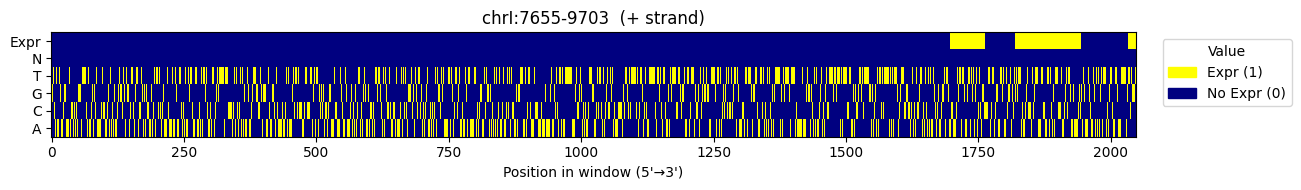

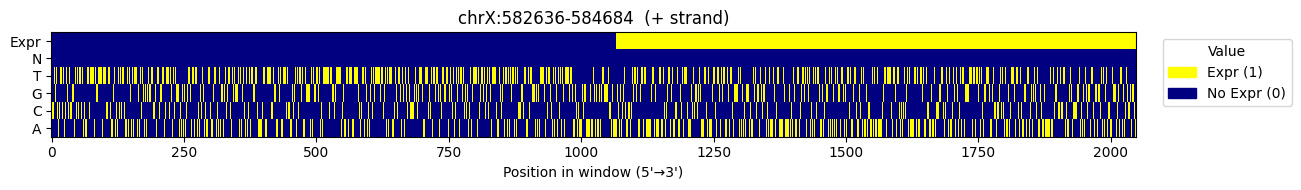

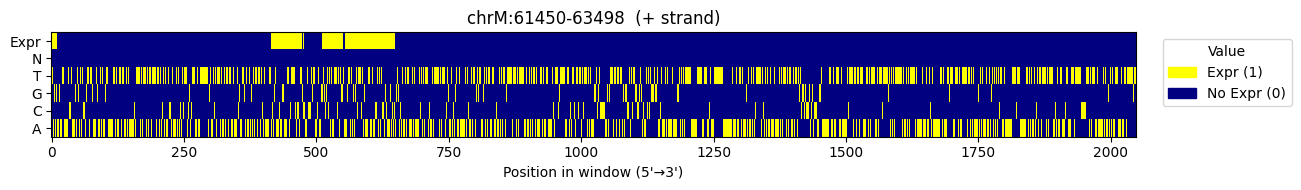

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# load once
data        = np.load(DATA_PATH)
seq_flat    = data['sequence']
expr_counts = data['expressed_plus']
expr_flat   = (expr_counts > 0).astype(int)  # binary expression

regions = pd.read_parquet(REGION_PATH)[['contig','strand','start','offset','window_size']]

# reverse‐complement helper
def revcomp(arr):
    rc = {0:3,1:2,2:1,3:0,4:4}
    return np.array([rc[b] for b in arr[::-1]], dtype=arr.dtype)

def plot_window(idx):
    row    = regions.iloc[idx]
    contig = row.contig
    strand = row.strand
    start  = row.start
    off    = row.offset
    L      = row.window_size

    seq_win  = seq_flat[off:off+L]
    expr_win = expr_flat[off:off+L]

    if strand == '-':
        seq_win  = revcomp(seq_win)
        expr_win = expr_win[::-1]

    # Build rows in your custom order: N,T,G,C,A
    base_codes  = [4, 3, 2, 1, 0]            # 4=N, 3=T, 2=G, 1=C, 0=A
    base_labels = ['N', 'T', 'G', 'C', 'A']

    rows   = [expr_win] + [(seq_win == b).astype(int) for b in base_codes]
    labels = ['Expr'] + base_labels

    mat = np.vstack(rows)

    fig, ax = plt.subplots(figsize=(13,2))
    cmap = ListedColormap(['navy','yellow'])
    ax.imshow(mat, aspect='auto', interpolation='nearest', cmap=cmap)

    # Set the tick labels in the same order
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_title(f"{contig}:{start}-{start+L}  ({strand} strand)")
    ax.set_xlabel("Position in window (5'→3')")

    # Legend
    legend_handles = [
        Patch(color='yellow', label='Expr (1)'),
        Patch(color='navy',   label='No Expr (0)')
    ]
    ax.legend(handles=legend_handles,
              loc='upper right',
              bbox_to_anchor=(1.15,1.0),
              title="Value")

    plt.tight_layout()
    plt.show()


plot_window(0)                 # first window
plot_window(len(regions)//2)   # middle window
plot_window(len(regions)-1)    # last window

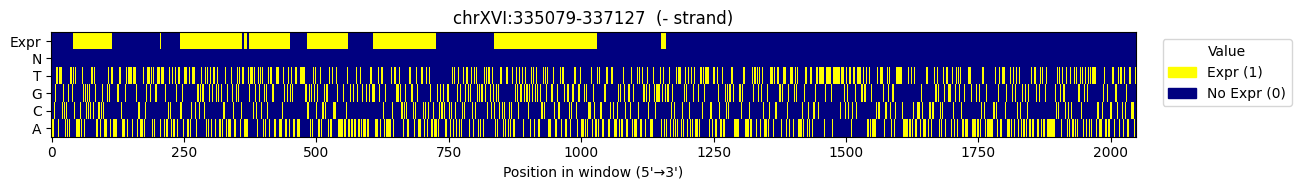

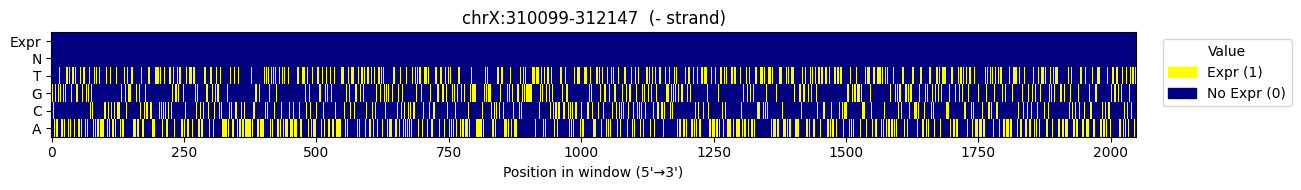

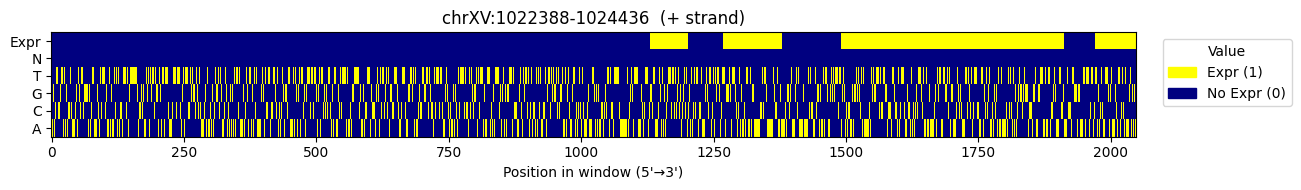

In [ ]:
# plot 3 random windows
np.random.seed(42)
for i in np.random.choice(len(regions), size=3, replace=False):
    plot_window(i)

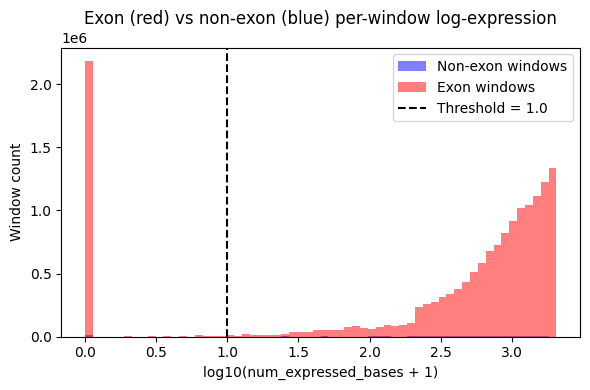

In [ ]:
# 2) Build a PyRanges of all windows (carry original index)
win_df = regions[['contig','start','window_size','offset']].copy()
win_df['Chromosome'] = win_df['contig']
win_df['Start']      = win_df['start']
win_df['End']        = win_df['start'] + win_df['window_size'] - 1
win_df['idx']        = win_df.index

pr_windows = pr.PyRanges(win_df[['Chromosome','Start','End','idx']])

# 3) Build a PyRanges of exons
exon_df = (gff3.query("type=='exon'")
              .assign(Chromosome=lambda df: 'chr' + df.seqid)
              [['Chromosome','start','end']]
              .rename(columns={'start':'Start','end':'End'}))
pr_exons = pr.PyRanges(exon_df)

# 4) Find which windows overlap exons
joined           = pr_windows.join(pr_exons)
exon_window_idxs = joined.df['idx'].unique().astype(int)

# 5) Build per-window binary mask
N       = len(regions)
is_exon = np.zeros(N, dtype=bool)
is_exon[exon_window_idxs] = True

# 6) Load expression‐plus array and compute per-window counts via prefix-sum
data       = np.load(DATA_PATH)
expr_flag  = (data['expressed_plus'] > 0).astype(np.int32)  # shape = total_bases
offsets    = regions['offset'].values.astype(int)
L          = int(regions['window_size'].iat[0])
total_bases = expr_flag.shape[0]

# prefix-sum array of length total_bases+1
cumsum = np.empty(total_bases+1, dtype=np.int32)
cumsum[0] = 0
np.cumsum(expr_flag, out=cumsum[1:])

# per-window count = cumsum[o+L] - cumsum[o]
starts = offsets
ends   = offsets + L
counts = cumsum[ends] - cumsum[starts]

# 7) Log10 transform
log_expr = np.log10(counts + 1)

# 8) Plot per-window histogram
plt.figure(figsize=(6,4))
bins = np.histogram_bin_edges(log_expr, bins=60)

plt.hist(log_expr[~is_exon], bins=bins, color='blue', alpha=0.5, label='Non-exon windows')
plt.hist(log_expr[ is_exon], bins=bins, color='red',  alpha=0.5, label='Exon windows')
plt.axvline(1.0, color='k', linestyle='--', label='Threshold = 1.0')
plt.xlabel("log10(num_expressed_bases + 1)")
plt.ylabel("Window count")
plt.title("Exon (red) vs non-exon (blue) per-window log-expression")
plt.legend()
plt.tight_layout()
plt.show()


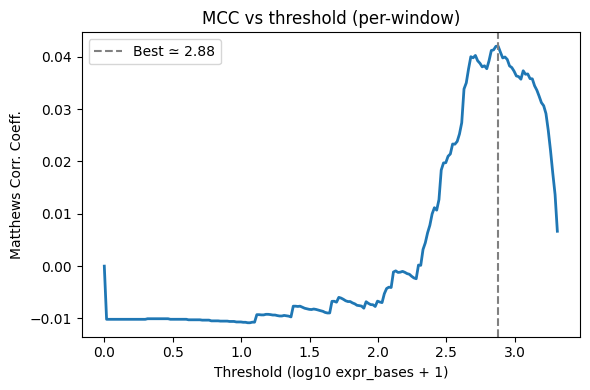

Optimal threshold = 2.879  (MCC = 0.042)


In [ ]:
# 9) Fast MCC sweep on a 200k-window random subset
from sklearn.metrics import matthews_corrcoef

np.random.seed(0)
sub_n   = min(200_000, N)
idx_sub = np.random.choice(N, sub_n, replace=False)
lab_sub = is_exon[idx_sub]
expr_sub= log_expr[idx_sub]

ths  = np.linspace(expr_sub.min(), expr_sub.max(), 200)
mccs = [matthews_corrcoef(lab_sub, expr_sub >= t) for t in ths]
best = int(np.argmax(mccs))

plt.figure(figsize=(6,4))
plt.plot(ths, mccs, lw=2)
plt.axvline(ths[best], color='gray', linestyle='--',
            label=f'Best ≃ {ths[best]:.2f}')
plt.xlabel("Threshold (log10 expr_bases + 1)")
plt.ylabel("Matthews Corr. Coeff.")
plt.title("MCC vs threshold (per-window)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Optimal threshold = {ths[best]:.3f}  (MCC = {mccs[best]:.3f})")